Opdracht: Inleveropdracht 4: Machine Translation & Document Search 
Naam: Onno de Jong <br>
Studentnummer: 1809878

In [219]:
#imports
import numpy as np
import matplotlib.pyplot as plt
import pickle
import math

import pandas as pd

Embeddings inladen

In [2]:
en, fr = pickle.loads(open('en_embeddings.p', 'rb').read()), pickle.loads(open('fr_embeddings.p', 'rb').read())

inladen train en test sets

In [3]:
train = pd.read_csv('en-fr.train.txt',sep=" ", names=['en', 'fr'])
test =  pd.read_csv('en-fr.test.txt',sep=" ", names=['en', 'fr'])

In [ ]:
train.sample(5)

In [5]:
test.sample(5)

,en,fr
1010,defining,définir
1105,deceased,décédés
1315,hurt,blessé
690,rescued,secouru
2586,capabilities,capacités


cleaning van de sets, er zijn een heel aantal worden, vooral bij de franse woorden, die niet in de embeddings zitten, die haal ik er uit omdat ik er geen informatie van weet

In [6]:
sum([x in fr.keys() for x in train['fr']]) / len(train)

0.5275938189845475

In [7]:
sum([x in en.keys() for x in train['en']]) / len(train)

0.9908020603384842

In [171]:
print(train.shape)
clean_train = train[train['en'].isin(en.keys())]
clean_train = clean_train[clean_train['fr'].isin(fr.keys())]
print(clean_train.shape)

(10872, 2)
(5717, 2)


In [172]:
print(test.shape)
clean_test = test[test['en'].isin(en.keys())]
clean_test = clean_test[clean_test['fr'].isin(fr.keys())]
print(clean_test.shape)

(2943, 2)
(1542, 2)


In [169]:
sum([x in fr.keys() for x in clean_train['fr']]) / len(clean_train)

1.0

In [170]:
sum([x in en.keys() for x in clean_train['en']]) / len(clean_train)

1.0

Frobenius norm <br> 
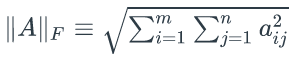

In [12]:
def frobenius(X):
    return np.sqrt(np.sum(X ** 2))

In [13]:
x = np.array([[2, 3], [1, 4], [2, 1]])

In [14]:
x

array([[2, 3],
       [1, 4],
       [2, 1]])

In [15]:
frobenius(x)

5.916079783099616

Loss functie <br>
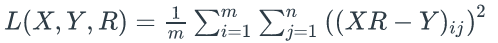

In [131]:
def loss(X, Y, R):
    return np.sum((X * R - Y) ** 2 ) / len(X)

Gradient
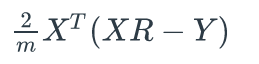

In [145]:
def gradient(X, Y, R):
#     print("X", X.shape)
#     print("Y", Y.shape)
#     print("R", R.shape)
    return X.T * (X * R - Y) * (2/len(X))

In [222]:
def gradient_descent(x, y, theta, alpha, num_iters):
    """
    eigenlijk een 1 layer neural network
    
    Input:
    x: embeddings van de engelse woorden (m, n)
    y: de bijbehorende franse woorden embeddings (m, n)
    theta: weights vector, dimensies (n + 1, 1)
    alpha: learning rate
    num_iters: aantal iterations om het model te trainen
    
    Output:
    J: de laatste loss
    theta: de geleerde weights vector
    """
    print("x", x.shape)
    print("y", y.shape)
    print("theta", theta.shape)
    print("alpha", alpha)
    print("epochs", num_iters)
    
    # loop over het aantal epochs heen
    for i in range(num_iters):
        for i in range(len(x)):
#             print("gradient", gradient(x[i], y[i], theta).shape)
        
            # het leren van de samples, learning rate / N samples * input * errors
            theta = theta - alpha * gradient(x[i], y[i], theta)
        J = loss(x, y, theta)
        print(J)
        
    return [J, theta]

In [215]:
def get_embeddings(n, tset):
    res = []
    for en_word, fr_word in tset[['en', 'fr']].values[:n]:
        res.append([en[en_word], fr[fr_word]])
        
    return np.array(res)

In [216]:
t = get_embeddings(len(clean_train), clean_train)

In [217]:
t[:, 0].shape

(5717, 300)

In [228]:
model = gradient_descent(t[:, 0], t[:, 1], np.random.rand(300), .8, 50)

x (5717, 300)
y (5717, 300)
theta (300,)
alpha 0.8
epochs 50
1.5053638300308414
1.0834179739358882
1.0061067861384738
0.9914917790434145
0.9886597025794135
0.9881015886053963
0.987991110195834
0.9879696746757184
0.9879658391806108
0.987965333917971
0.9879653698659685
0.9879654450132924
0.9879654928603883
0.9879655180753172
0.987965530536362
0.9879655365402441
0.9879655394043393
0.9879655407663303
0.9879655414140286
0.9879655417225288
0.9879655418698116
0.9879655419403196
0.9879655419741736
0.9879655419904781
0.9879655419983545
0.9879655420021711
0.9879655420040268
0.9879655420049319
0.9879655420053743
0.9879655420055907
0.9879655420056968
0.98796554200575
0.9879655420057749
0.9879655420057888
0.9879655420057956
0.9879655420057977
0.9879655420057999
0.987965542005801
0.987965542005801
0.987965542005801
0.987965542005801
0.9879655420058009
0.9879655420058011
0.9879655420058011
0.987965542005801
0.9879655420058011
0.9879655420058011
0.9879655420058011
0.9879655420058011
0.9879655420058011

In [196]:
model

-0.020395990011929717

In [153]:
def cosine_dist(A : np.array, B : np.array) -> float:
    if (A.size != B.size):
        return
    
    return np.matmul(A, B) / (np.sqrt(np.sum(A ** 2)) * np.sqrt(np.sum(B ** 2)))

In [158]:
def predict(en_word, en_words, fr_words, R):
    target = en_words[en_word] * R
    closest = [-1, ""]
    for index, embedding in fr_words.items():
        if (i:=cosine_dist(embedding, target)) > closest[0]:
            closest = [i, index]
    return closest

In [191]:
def accuracy(word_dict, en_words, fr_words, R):
    total = 0
    count = 0
    for en_word, fr_word in word_dict[['en', 'fr']].values:
        count += 1
        print(count) if count % 100 == 0 else None
        if (i:=predict(en_word, en_words, fr_words, R))[1] == fr_word:
            print("OMG NO FUCKING WAY")
            total += 1
#         print(i, fr_word)
    return total / len(word_dict)

In [195]:
accuracy(clean_train, en, fr, model[1])

100
200


KeyboardInterrupt: 

the le
the les
the la
and et
was fut
was etait
was était
for pour
that que
that cela
with avec
from du
from de
from depuis
this ceci
this cet
this cette
this cela
this ce
utc utc
utc tuc
his sa
his his
his ses
his son
not not
not non
not pas
are sont
talk parler
talk parle
talk talk
talk parlez
which lesquels
which laquelle
which lequel
also également
also aussi
also egalement
were étaient
but mais
have avoir
have ont
one un
one une
one one
new nouveau
new nouvelle
new nouvelles
new nouveaux
new nouveautés
first première
first premières
first premier
first premiers
page pages
page page
you vous
you tu
you toi
you you
they elles
they ils
they eux
had avait
had avaient
had avais
article article
who qui
who oms
who who
all toute
all toutes
all tous
all tout
all all
their leur
their leurs
there là
made fait
made fabriqués
made faite
made fabriqué
its sa
its ses
its son
people gens
people personnes
may mai
may may
may peut
after apres
after after
after après
after aprés
other autre
other au